# Hotel Booking Demand
This dataset consists of booking data from a city hotel and a resort hotel. It includes many details about the bookings, including room specifications, the length of stay, the time between the booking and the stay, whether the booking was canceled, and how the booking was made. The data was gathered between July 2015 and August 2017.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

# Reading in the data source
bookings = pd.read_csv("datasets/hotel_bookings_clean.csv")

In [3]:
bookings.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,27,1,7,0,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,737,27,1,7,0,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,7,27,1,7,0,1,1,0.0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,13,27,1,7,0,1,1,0.0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,14,27,1,7,0,2,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0


In [4]:
# Creating a correlation matrix
corr_matrix = bookings.corr()
corr_matrix.style.background_gradient()

In [5]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [6]:
# Import the train_test_split function
from sklearn.model_selection import train_test_split

bookings = clean_dataset(bookings)

# Creating features
features = bookings.drop(
            ['is_canceled', 'arrival_date_week_number', 'arrival_date_month',
             'booked_by_company', 'booked_by_agent', 'market_segment_Corporate',
             'market_segment_Direct', 'distribution_channel_Corporate'], axis=1).values

# Creating labels
labels = bookings['is_canceled'].values

# Splitting the dataset into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

In [7]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scaling the train and test features
scaler = StandardScaler()

# Normalizing the train features
scaled_train_features = scaler.fit_transform(train_features)

# Normalizing the test features
scaled_test_features = scaler.transform(test_features)

Text(0.5, 0, 'Principal Component #')

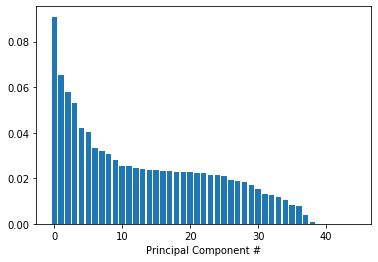

In [8]:
# Making sure the plots appear in the notebook
%matplotlib inline

# Importing the plotting module and the PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_ratio_

# Plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

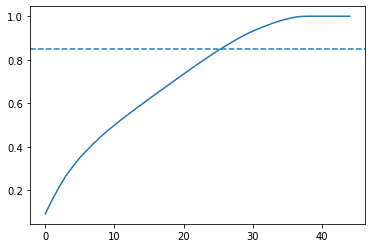

In [9]:
# Calculating the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [10]:
# Performing PCA with 28 components and project data onto those components
pca = PCA(n_components=28, random_state=10)

# Fit and transform the scaled training features
train_pca = pca.fit_transform(scaled_train_features)

# Transform the scaled test features
test_pca = pca.transform(scaled_test_features)

In [11]:
# Import the decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Train the decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

<p>For the class labels, "0.0" implies the hotel booking was not canceled and "1.0" implies the hotel booking was canceled.</p>

In [12]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train the logistic regression and predict the labels for the test set
logreg = LogisticRegression(random_state=10)

# Fit the model according to the given training data
logreg.fit(train_pca, train_labels)

# Predict class labels for samples in the test data
pred_labels_logit = logreg.predict(test_pca)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84     18804
         1.0       0.72      0.74      0.73     10998

    accuracy                           0.80     29802
   macro avg       0.78      0.79      0.79     29802
weighted avg       0.80      0.80      0.80     29802

Logistic Regression: 
               precision    recall  f1-score   support

         0.0       0.78      0.93      0.85     18804
         1.0       0.82      0.55      0.66     10998

    accuracy                           0.79     29802
   macro avg       0.80      0.74      0.76     29802
weighted avg       0.80      0.79      0.78     29802



In [13]:
"""
# Subset only the canceled bookings, and then only the non-canceled bookings
canceled = bookings[bookings['is_canceled'] == 1]
not_canceled = bookings[bookings['is_canceled'] == 0]

# Sample the non_canceled bookings to be the same number as canceled bookings
not_canceled = not_canceled.sample(len(canceled), random_state=10)

# Concatenate the canceled and not_canceled DataFrames
bookings_bal = pd.concat([canceled, not_canceled])

# Features for the balanced dataframe
features = bookings_bal.drop(
            ['is_canceled', 'arrival_date_week_number', 'arrival_date_month',
             'booked_by_company', 'booked_by_agent', 'market_segment_Corporate',
             'market_segment_Direct', 'distribution_channel_Corporate'], axis=1).values

# Labels for the balanced dataframe
labels = bookings_bal['is_canceled'].values

# Splitting the dataset into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

# Scaling the train and test features and performing PCA projection
train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))
"""

"\n# Subset only the canceled bookings, and then only the non-canceled bookings\ncanceled = bookings[bookings['is_canceled'] == 1]\nnot_canceled = bookings[bookings['is_canceled'] == 0]\n\n# Sample the non_canceled bookings to be the same number as canceled bookings\nnot_canceled = not_canceled.sample(len(canceled), random_state=10)\n\n# Concatenate the canceled and not_canceled DataFrames\nbookings_bal = pd.concat([canceled, not_canceled])\n\n# Features for the balanced dataframe\nfeatures = bookings_bal.drop(\n            ['is_canceled', 'arrival_date_week_number', 'arrival_date_month',\n             'booked_by_company', 'booked_by_agent', 'market_segment_Corporate',\n             'market_segment_Direct', 'distribution_channel_Corporate'], axis=1).values\n\n# Labels for the balanced dataframe\nlabels = bookings_bal['is_canceled'].values\n\n# Splitting the dataset into train and test sets\ntrain_features, test_features, train_labels, test_labels = train_test_split(features, labels, ra

In [14]:
# Train the decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train the logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Compare the classification reports
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84     18804
         1.0       0.72      0.74      0.73     10998

    accuracy                           0.80     29802
   macro avg       0.78      0.79      0.79     29802
weighted avg       0.80      0.80      0.80     29802

Logistic Regression: 
               precision    recall  f1-score   support

         0.0       0.78      0.93      0.85     18804
         1.0       0.82      0.55      0.66     10998

    accuracy                           0.79     29802
   macro avg       0.80      0.74      0.76     29802
weighted avg       0.80      0.79      0.78     29802



In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

# Set up the two pipelines
tree_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=28)),
                      ('tree', DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=28)),
                        ('logreg', LogisticRegression(random_state=10))])

# Set-up the K-Fold cross validation
kf = KFold(n_splits=10)

# Train the models using K-Fold CV
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))